In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.metrics import classification_report_imbalanced

### Import CSV and Perform Data Cleaning

In [4]:
columns = ["actual_duration", "study_type", "fda_regulated_drug",
           "fda_regulated_device", "responsible_party", "enrollemnt_count"]

target = ["status"]

In [5]:
# Load the interventional_study_only
file_path = Path('../Tables/ivs_vs_obs.csv')
df = pd.read_csv(file_path)

In [6]:
# Examine DataFrame
df.dtypes

ID                       object
title                    object
actual_duration         float64
status                   object
study_type               object
fda_regulated_drug       object
fda_regulated_device     object
responsible_party        object
enrollment_count          int64
dtype: object

In [7]:
# Drop null row .dropna()
df = df.dropna()

# Drop ID and title columns
df = df.drop(['ID', 'title'], axis=1)
df

,actual_duration,status,study_type,fda_regulated_drug,fda_regulated_device,responsible_party,enrollment_count
0,7.638356,Recruiting,Observational,No,No,Sponsor,3000
1,1.002740,Not yet recruiting,Observational,No,No,Principal Investigator,2300
2,0.693151,Unknown status,Observational,No,No,Principal Investigator,80
3,4.835616,Recruiting,Observational,No,No,Sponsor,30
4,3.936986,Unknown status,Observational,No,No,Sponsor,600
...,...,...,...,...,...,...,...
5014,2.336986,Completed,Interventional,No,No,Principal Investigator,80
5015,6.005479,Not yet recruiting,Interventional,No,No,Sponsor-Investigator,180
5016,3.750685,"Active, not recruiting",Interventional,Yes,No,Sponsor,38
5017,6.000000,Recruiting,Interventional,No,No,Sponsor-Investigator,80


In [8]:
duration_avr = df['actual_duration'].mean()
print(duration_avr)

3.3464529197675352


In [9]:
# Remove "Unknown" ("recruiting", "not yet recruiting", "Active, not recruiting", "Enrolling by invitation"?) status
unknown_stat = df['status'] != 'Unknown status'
df = df.loc[unknown_stat]

# Take out all other extras status
# not_yet_recruiting_stat = df['status'] != 'Not yet recruiting'
# df = df.loc[not_yet_recruiting_stat]

# active_not_recruiting_stat = df['status'] != 'Active, not recruiting'
# df = df.loc[active_not_recruiting_stat]

# enrolling_by_invitation_stat = df['status'] != 'Enrolling by invitation' 
# df = df.loc[enrolling_by_invitation_stat]

# recruiting_stat = df['status'] != 'Recruiting'
# df = df.loc[recruiting_stat]

df


,actual_duration,status,study_type,fda_regulated_drug,fda_regulated_device,responsible_party,enrollment_count
0,7.638356,Recruiting,Observational,No,No,Sponsor,3000
1,1.002740,Not yet recruiting,Observational,No,No,Principal Investigator,2300
3,4.835616,Recruiting,Observational,No,No,Sponsor,30
6,2.671233,Recruiting,Observational,No,No,Principal Investigator,271
7,2.712329,Recruiting,Observational,No,No,Sponsor,316
...,...,...,...,...,...,...,...
5014,2.336986,Completed,Interventional,No,No,Principal Investigator,80
5015,6.005479,Not yet recruiting,Interventional,No,No,Sponsor-Investigator,180
5016,3.750685,"Active, not recruiting",Interventional,Yes,No,Sponsor,38
5017,6.000000,Recruiting,Interventional,No,No,Sponsor-Investigator,80


In [10]:
# Convert the target Column values to low_chance and high_chance based in their values
# x = {'Completed' : 'high_chance'}
# df = df.replace(x)

x = dict.fromkeys(['Completed','Recruiting', 'Enrolling by invitation'], 'high_chance')
df = df.replace(x)

x = dict.fromkeys(['Withdrawn', 'Terminated', 'Suspended', 'Not yet recruiting', 'Active, not recruiting'], 'low_chance')
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,actual_duration,status,study_type,fda_regulated_drug,fda_regulated_device,responsible_party,enrollment_count
0,7.638356,high_chance,Observational,No,No,Sponsor,3000
1,1.002740,low_chance,Observational,No,No,Principal Investigator,2300
2,4.835616,high_chance,Observational,No,No,Sponsor,30
3,2.671233,high_chance,Observational,No,No,Principal Investigator,271
4,2.712329,high_chance,Observational,No,No,Sponsor,316


### Split the Data into Training and Testing

In [11]:
# Create our features
X = pd.get_dummies(df, columns=['study_type', 'fda_regulated_drug', 'fda_regulated_device', 
                                'responsible_party'], dtype=int).drop('status', axis=1)

# Create our target
y = df['status']
X.head()

,actual_duration,enrollment_count,study_type_Interventional,study_type_Observational,fda_regulated_drug_No,fda_regulated_drug_Yes,fda_regulated_device_No,fda_regulated_device_Yes,responsible_party_Principal Investigator,responsible_party_Sponsor,responsible_party_Sponsor-Investigator
0,7.638356,3000,0,1,1,0,1,0,0,1,0
1,1.002740,2300,0,1,1,0,1,0,1,0,0
2,4.835616,30,0,1,1,0,1,0,0,1,0
3,2.671233,271,0,1,1,0,1,0,1,0,0
4,2.712329,316,0,1,1,0,1,0,0,1,0


In [12]:
# Check count, mean, max for features
X.describe()

,actual_duration,enrollment_count,study_type_Interventional,study_type_Observational,fda_regulated_drug_No,fda_regulated_drug_Yes,fda_regulated_device_No,fda_regulated_device_Yes,responsible_party_Principal Investigator,responsible_party_Sponsor,responsible_party_Sponsor-Investigator
count,4505.000000,4.505000e+03,4505.000000,4505.000000,4505.000000,4505.000000,4505.000000,4505.000000,4505.000000,4505.000000,4505.000000
mean,3.484832,5.270109e+03,0.801554,0.198446,0.753163,0.246837,0.944062,0.055938,0.345172,0.608657,0.046171
std,2.799562,2.108772e+05,0.398874,0.398874,0.431219,0.431219,0.229827,0.229827,0.475477,0.488105,0.209878
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.668493,3.600000e+01,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.997260,8.400000e+01,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,4.580822,2.250000e+02,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,50.786301,1.000000e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# Check the balance of our target values
y.value_counts()

status
high_chance    3091
low_chance     1414
Name: count, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
print(Counter(y_train))
print(Counter(y_test))

Counter({'high_chance': 2318, 'low_chance': 1060})
Counter({'high_chance': 773, 'low_chance': 354})


### Random Forest Classifier

In [15]:
# Create random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)

# Fit the model
rf_model = rf_model.fit(X_train, y_train)

In [16]:
# Create prediction
y_pred = rf_model.predict(X_test)

In [17]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual High Chance', 'Actual Low chance'], columns = ['Predicted High Chance', 'Predicted Low Chance'])
cm_df

,Predicted High Chance,Predicted Low Chance
Actual High Chance,642,131
Actual Low chance,243,111


In [18]:
# Calculate accuracy score
acc_score = accuracy_score(y_test, y_pred)
bal_acc_score = balanced_accuracy_score(y_test, y_pred)

# Print results
print("Random Forest Classifier Results\n")
print("Confusion Matrix")
display(cm_df)
print(f'Accuracy Score: {acc_score}')
print(f'Balanced Accuracy Score: {bal_acc_score}')
print("---------------------------")
print("Classfication Report")
print(classification_report_imbalanced(y_test, y_pred))

Random Forest Classifier Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,642,131
Actual Low chance,243,111


Accuracy Score: 0.6681455190771961
Balanced Accuracy Score: 0.5720448615344136
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

high_chance       0.73      0.83      0.31      0.77      0.51      0.27       773
 low_chance       0.46      0.31      0.83      0.37      0.51      0.25       354

avg / total       0.64      0.67      0.48      0.65      0.51      0.27      1127



### Balanced Random Forest Classifier

In [19]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Instantiate model
classifier = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

# Fit model
classifier.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=1)

In [20]:
# Calculated the balanced accuracy score
y_pred = classifier.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5873805921605602

In [21]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual High Chance', 'Actual Low chance'], 
                     columns = ['Predicted High Chance', 'Predicted Low Chance'])
cm_df

,Predicted High Chance,Predicted Low Chance
Actual High Chance,467,306
Actual Low chance,152,202


In [22]:
# Calculate accuracy score
acc_score = accuracy_score(y_test, y_pred)
bal_acc_score = balanced_accuracy_score(y_test, y_pred)

# Print results
print("Balanced Random Forest Classifier\n")
print("Confusion Matrix")
display(cm_df)
print(f'Accuracy Score: {acc_score}')
print(f'Balanced Accuracy Score: {bal_acc_score}')
print("---------------------------")
print("Classfication Report")
print(classification_report_imbalanced(y_test, y_pred))

Balanced Random Forest Classifier

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,467,306
Actual Low chance,152,202


Accuracy Score: 0.5936113575865128
Balanced Accuracy Score: 0.5873805921605602
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

high_chance       0.75      0.60      0.57      0.67      0.59      0.35       773
 low_chance       0.40      0.57      0.60      0.47      0.59      0.34       354

avg / total       0.64      0.59      0.58      0.61      0.59      0.35      1127



In [23]:
# Calculate feature importance
rf_importances = rf_model.feature_importances_

# sort features by importance
sorted(zip(rf_importances, X.columns), reverse=True)

[(0.49633112695397424, 'actual_duration'),
 (0.4702630969890361, 'enrollment_count'),
 (0.004565521726169511, 'responsible_party_Sponsor'),
 (0.004162169022770596, 'responsible_party_Principal Investigator'),
 (0.004095176167899441, 'fda_regulated_drug_No'),
 (0.0040240425310494226, 'fda_regulated_drug_Yes'),
 (0.0038168057216505943, 'study_type_Interventional'),
 (0.003664615856819901, 'study_type_Observational'),
 (0.003442317368244861, 'fda_regulated_device_Yes'),
 (0.002832793211361952, 'responsible_party_Sponsor-Investigator'),
 (0.0028023344510233078, 'fda_regulated_device_No')]

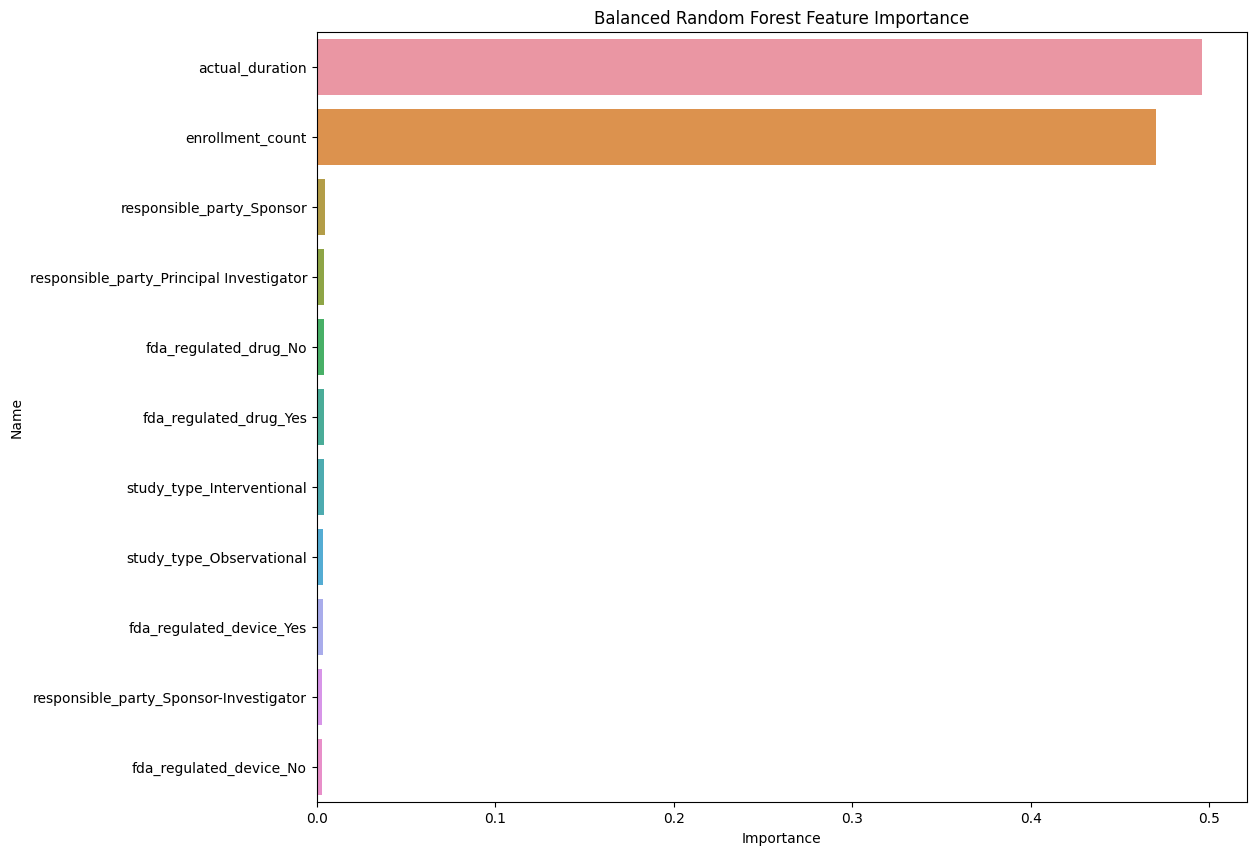

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# define function to plot feature importance
def plot_importance (importance, names, model_type):

    df = pd.DataFrame({'Names':names, 'Importance':importance})
    df.sort_values(by=['Importance'], ascending=False, inplace=True)

    plt.figure(figsize=(12,10))
    sns.barplot(x=df['Importance'], y=df['Names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Name')

    plt.show()

plot_importance(rf_importances, X.columns, 'Balanced Random Forest')

### Logistic Regression

In [25]:
# Declare model
lr_model = LogisticRegression(solver='lbfgs', random_state=42)

# fit the model
lr_model = lr_model.fit(X_train, y_train)

In [26]:
# create prediction
y_pred = lr_model.predict(X_test)

In [27]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual High Chance', 'Actual Low chance'], 
                     columns = ['Predicted High Chance', 'Predicted Low Chance'])
cm_df

,Predicted High Chance,Predicted Low Chance
Actual High Chance,773,0
Actual Low chance,354,0


In [28]:
# Calculate accuracy score
acc_score = accuracy_score(y_test, y_pred)
bal_acc_score = balanced_accuracy_score(y_test, y_pred)

# Print results
print("Logistic Regression Model Results\n")
print("Confusion Matrix")
display(cm_df)
print(f'Accuracy Score: {acc_score}')
print(f'Balanced Accuracy Score: {bal_acc_score}')
print("---------------------------")
print("Classfication Report")
print(classification_report_imbalanced(y_test, y_pred))

Logistic Regression Model Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,773,0
Actual Low chance,354,0


Accuracy Score: 0.6858917480035492
Balanced Accuracy Score: 0.5
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

high_chance       0.69      1.00      0.00      0.81      0.00      0.00       773
 low_chance       0.00      0.00      1.00      0.00      0.00      0.00       354

avg / total       0.47      0.69      0.31      0.56      0.00      0.00      1127



### Optimize model, Use resampling techniques to determine the best performing algorithm

### Oversampling

##### Naive Random Oversampling

In [29]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
# Instantiate the model
ros = RandomOverSampler(random_state=1)
# Resample the targets
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_chance': 2318, 'high_chance': 2318})

In [30]:
# Train the BalancedRandomForestClassifier model using the resampled data
from imblearn.ensemble import BalancedRandomForestClassifier
classifier = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

# Fit model
classifier.fit(X_resampled, y_resampled)

BalancedRandomForestClassifier(random_state=1)

In [31]:
# Calculated the predictions
y_pred = classifier.predict(X_test)

In [32]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.5707237924002895

In [33]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[581, 192],
       [216, 138]], dtype=int64)

In [34]:
# Create dataframe for confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Actual high_risk", "Actual low_risk"], columns=["Predicted high_risk", "Predicted low_risk"])
cm_df

,Predicted high_risk,Predicted low_risk
Actual high_risk,581,192
Actual low_risk,216,138


In [35]:
# Calculate accuracy score
acc_score = accuracy_score(y_test, y_pred)
bal_acc_score = balanced_accuracy_score(y_test, y_pred)

# Print results
print("Naive Random OverSampling Results\n")
print("Confusion Matrix")
display(cm_df)
print(f'Accuracy Score: {acc_score}')
print(f'Balanced Accuracy Score: {bal_acc_score}')
print("---------------------------")
print("Classfication Report")
print(classification_report_imbalanced(y_test, y_pred))

Naive Random OverSampling Results

Confusion Matrix


,Predicted high_risk,Predicted low_risk
Actual high_risk,581,192
Actual low_risk,216,138


Accuracy Score: 0.6379769299023957
Balanced Accuracy Score: 0.5707237924002895
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

high_chance       0.73      0.75      0.39      0.74      0.54      0.30       773
 low_chance       0.42      0.39      0.75      0.40      0.54      0.28       354

avg / total       0.63      0.64      0.50      0.63      0.54      0.30      1127



##### SMOTE Oversampling

In [36]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE

# Instantiate the model
smote = SMOTE(random_state=1)

# Resample the targets
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_chance': 2318, 'high_chance': 2318})

In [37]:
# Train the Logistic Regression model using the resampled data
classifier.fit(X_resampled, y_resampled)

BalancedRandomForestClassifier(random_state=1)

In [38]:
# Calculated the balanced accuracy score
y_pred = classifier.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5761231828447387

In [39]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create dataframe confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Actual high_risk", "Actual low_risk"], columns=["Predicted high_risk", "Predicted low_risk"])
cm_df

,Predicted high_risk,Predicted low_risk
Actual high_risk,609,164
Actual low_risk,225,129


In [40]:
# Calculate accuracy score
acc_score = accuracy_score(y_test, y_pred)
bal_acc_score = balanced_accuracy_score(y_test, y_pred)

# Print results
print("SMOTE Results\n")
print("Confusion Matrix")
display(cm_df)
print(f'Accuracy Score: {acc_score}')
print(f'Balanced Accuracy Score: {bal_acc_score}')
print("---------------------------")
print("Classfication Report")
print(classification_report_imbalanced(y_test, y_pred))

SMOTE Results

Confusion Matrix


,Predicted high_risk,Predicted low_risk
Actual high_risk,609,164
Actual low_risk,225,129


Accuracy Score: 0.6548358473824313
Balanced Accuracy Score: 0.5761231828447387
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

high_chance       0.73      0.79      0.36      0.76      0.54      0.30       773
 low_chance       0.44      0.36      0.79      0.40      0.54      0.27       354

avg / total       0.64      0.65      0.50      0.65      0.54      0.29      1127



### Undersampling

In [41]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import ClusterCentroids

# Instantiate the model
Cluster_resample = ClusterCentroids(random_state=1)
X_resampled, y_resampled = Cluster_resample.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_chance': 1060, 'low_chance': 1060})

In [42]:
# Train the BalancedRandomForestClassifier model using the resampled data
classifier.fit(X_resampled, y_resampled)

BalancedRandomForestClassifier(random_state=1)

In [43]:
# Calculated the balanced accuracy score
y_pred = classifier.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5509059281835391

In [44]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create Dataframe from the confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Actual high_risk", "Actual low_risk"], columns=["Predicted high_risk", "Predicted low_risk"])
cm_df

,Predicted high_risk,Predicted low_risk
Actual high_risk,332,441
Actual low_risk,116,238


In [45]:
# Calculate accuracy score
acc_score = accuracy_score(y_test, y_pred)
bal_acc_score = balanced_accuracy_score(y_test, y_pred)

# Print results
print("Cluster Centroids Results\n")
print("Confusion Matrix")
display(cm_df)
print(f'Accuracy Score: {acc_score}')
print(f'Balanced Accuracy Score: {bal_acc_score}')
print("---------------------------")
print("Classfication Report")
print(classification_report_imbalanced(y_test, y_pred))

Cluster Centroids Results

Confusion Matrix


,Predicted high_risk,Predicted low_risk
Actual high_risk,332,441
Actual low_risk,116,238


Accuracy Score: 0.5057675244010648
Balanced Accuracy Score: 0.5509059281835391
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

high_chance       0.74      0.43      0.67      0.54      0.54      0.28       773
 low_chance       0.35      0.67      0.43      0.46      0.54      0.30       354

avg / total       0.62      0.51      0.60      0.52      0.54      0.29      1127



### Combination (Over and Under) Sampling

In [46]:
# Resample the training data with SMOTEENN
from imblearn.combine import SMOTEENN
smoteenn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smoteenn.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_chance': 742, 'low_chance': 1010})

In [47]:
# Train the BalancedRandomForestClassifier model using the resampled data
classifier.fit(X_resampled, y_resampled)

BalancedRandomForestClassifier(random_state=1)

In [48]:
# Calculated the balanced accuracy score
y_pred = classifier.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5691670138355954

In [49]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual high_risk", "Actual low_risk"], columns=["Predicted high_risk", "Predicted low_risk"])
cm_df

,Predicted high_risk,Predicted low_risk
Actual high_risk,631,142
Actual low_risk,240,114


In [50]:
# Calculate accuracy score
acc_score = accuracy_score(y_test, y_pred)
bal_acc_score = balanced_accuracy_score(y_test, y_pred)

# Print results
print("SMOTEENN Results\n")
print("Confusion Matrix")
display(cm_df)
print(f'Accuracy Score: {acc_score}')
print(f'Balanced Accuracy Score: {bal_acc_score}')
print("---------------------------")
print("Classfication Report")
print(classification_report_imbalanced(y_test, y_pred))

SMOTEENN Results

Confusion Matrix


,Predicted high_risk,Predicted low_risk
Actual high_risk,631,142
Actual low_risk,240,114


Accuracy Score: 0.6610470275066548
Balanced Accuracy Score: 0.5691670138355954
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

high_chance       0.72      0.82      0.32      0.77      0.51      0.28       773
 low_chance       0.45      0.32      0.82      0.37      0.51      0.25       354

avg / total       0.64      0.66      0.48      0.64      0.51      0.27      1127

